<a href="https://colab.research.google.com/github/j-physics/Mech_Interp_Exploratory/blob/main/singlelayer_FAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install transformer-lens

In [28]:
#import necessary libraries or packages
import torch
import transformer_lens
from transformer_lens import HookedTransformer

#check GPU is working right
print(f"GPU available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

GPU available: True
Device: NVIDIA L4


In [29]:
#load a small model (e.g., gpt2-small, pythia-70m)
model = HookedTransformer.from_pretrained("pythia-70m", device="cuda")

#check to see model is loading
text = "Hi, my name is Jessica."
tokens = model.to_tokens(text)
logits = model(tokens)
print(f"Tokens shape: {tokens.shape}")
print(f"Logits shape: {logits.shape}")


Loaded pretrained model pythia-70m into HookedTransformer
Tokens shape: torch.Size([1, 8])
Logits shape: torch.Size([1, 8, 50304])


In [30]:
!pip install sae_lens

In [31]:
#integrate SAEs from TransformerLens
from transformer_lens import HookedTransformer
from sae_lens import SAE

#Load SAE for a specific layer(s)
sae, cfg_dict, sparsity = SAE.from_pretrained_with_cfg_and_sparsity(
    release="ctigges/pythia-70m-deduped__res-sm_processed",
    sae_id="2-res-sm",
    device="cuda"
)

In [32]:
#feature activation analysis (FAA)

#Testing some text out
text = "There is a tiger in the room"
tokens = model.to_tokens(text)

#Getting the activations at a single layer
_, cache = model.run_with_cache(tokens)
layer_acts = cache["blocks.2.hook_resid_post"]

#Run through SAE to get feature activations of singlelayer
feature_acts = sae.encode(layer_acts)

#Seeing which features fired
print(f"Shape: {feature_acts.shape}") #should be in the format [batch, seq_len, num_feat]
print(f"Non-zero features: {(feature_acts > 0).sum()}")

#Find the top activating features
top_features = feature_acts[0, -1].topk(10) #top 10 at the last token
print(f"Top features: {top_features.indices}")
print(f"Activations: {top_features.values}")

Shape: torch.Size([1, 8, 32768])
Non-zero features: 8739
Top features: tensor([27045, 32604, 16978, 17575, 23734, 19777, 14190,  6079,  7552, 20236],
       device='cuda:0')
Activations: tensor([1.5125, 1.2771, 1.2396, 1.2269, 0.8035, 0.7915, 0.7530, 0.7471, 0.7292,
        0.6755], device='cuda:0', grad_fn=<TopkBackward0>)


In [33]:
#Looking at each token position now
tokens_str = model.to_str_tokens(text)
print("Tokens:", tokens_str)

# for pos in range(len(tokens_str)):
#   top_at_pos = feature_acts[0, pos].topk(5)
#   print(f"\nToken {pos} ('{tokens_str[pos]}'):")
#   print(f" Top features: {top_at_pos.indices.tolist()}")
#   #print(f" Activations: {top_at_pos.values.tolist()}")

#nice format to show what sentence I am analyzing
print("=" * 60)
print(f"Analyzing: '{text}'")
print("=" * 60)

#What top features activate for each token
for pos, token in enumerate(tokens_str):
  top_features = feature_acts[0, pos].topk(3) #top three features
  print(f"\nPosition {pos}: '{token}'")
  print(f" Top 3 features: {top_features.indices.tolist()}")
  print(f" Activations: {[f'{x: .3f}' for x in top_features.values.tolist()]}")


Tokens: ['<|endoftext|>', 'There', ' is', ' a', ' tiger', ' in', ' the', ' room']
Analyzing: 'There is a tiger in the room'

Position 0: '<|endoftext|>'
 Top 3 features: [11698, 3599, 25082]
 Activations: [' 31.524', ' 13.575', ' 12.890']

Position 1: 'There'
 Top 3 features: [17575, 27823, 14467]
 Activations: [' 0.516', ' 0.454', ' 0.342']

Position 2: ' is'
 Top 3 features: [11698, 17475, 8192]
 Activations: [' 0.389', ' 0.272', ' 0.271']

Position 3: ' a'
 Top 3 features: [7077, 26322, 6942]
 Activations: [' 0.784', ' 0.525', ' 0.360']

Position 4: ' tiger'
 Top 3 features: [16147, 21516, 27099]
 Activations: [' 0.977', ' 0.920', ' 0.816']

Position 5: ' in'
 Top 3 features: [15823, 15055, 30441]
 Activations: [' 1.009', ' 0.988', ' 0.972']

Position 6: ' the'
 Top 3 features: [19019, 2863, 25063]
 Activations: [' 1.447', ' 1.359', ' 1.177']

Position 7: ' room'
 Top 3 features: [27045, 32604, 16978]
 Activations: [' 1.512', ' 1.277', ' 1.240']


In [37]:
#What about for some other sentences? (including the previous test text)
test_sentences = {
    "original": "The tiger is in the room",
    "changed_subject": "The wolf is in the room", #changing the subject
    "changed_verb": "The tiger jumped in the room", #change of verb
    "multiple_subjects": "The tiger and the wolf are in the room", #multiple subjects
}

#collect the activations for each sentence
results = {}

for name, sentence in test_sentences.items():
  tokens = model.to_tokens(sentence)
  tokens_str = model.to_str_tokens(sentence)

  _, cache = model.run_with_cache(tokens)
  layer_activate = cache["blocks.2.hook_resid_post"]
  feature_activate = sae.encode(layer_activate)

  results[name] = {
        'tokens': tokens_str,
        'activations': feature_activate[0] #[seq_len, num_features]
  }

#Comparing which features appear in ALL variations
#Getting the top features from each
all_top_features = []
for name, data in results.items():
    top = data['activations'][-1].topk(10).indices.tolist() #last token
    all_top_features.extend(top)

#Find common features
from collections import Counter
feature_counts = Counter(all_top_features)

print("=" * 60)
print("Feature Consistency Analysis")
print("=" * 60)
print("\nFeatures that appear most frequently across variations:")
for feat, count in feature_counts.most_common(10):
  print(f"   Feature {feat}: appears in {count}/{len(test_sentences)} variations")


Feature Consistency Analysis

Features that appear most frequently across variations:
   Feature 32604: appears in 4/4 variations
   Feature 27045: appears in 3/4 variations
   Feature 11175: appears in 3/4 variations
   Feature 24101: appears in 3/4 variations
   Feature 3939: appears in 3/4 variations
   Feature 16978: appears in 3/4 variations
   Feature 23288: appears in 3/4 variations
   Feature 17575: appears in 3/4 variations
   Feature 1770: appears in 3/4 variations
   Feature 1437: appears in 2/4 variations


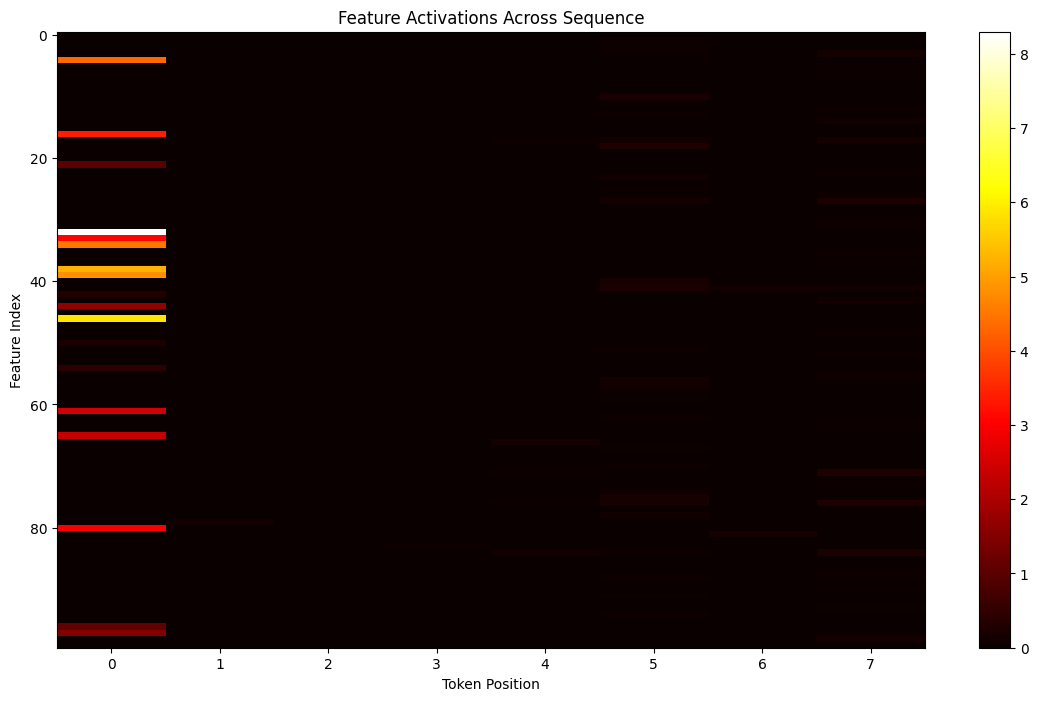

In [38]:
#let's visualize what is happening
import matplotlib.pyplot as plt

#Generate a heatmap of feature activations across tokens
activations = feature_acts[0].cpu().detach() # [seq_len, num_featueres]

#Just plotting features that activated
active_mask = (activations > 0).any(dim=0)
active_features = activations[:, active_mask]

plt.figure(figsize=(14,8))
plt.imshow(active_features.T[:100], aspect='auto', cmap='hot')
plt.xlabel('Token Position')
plt.ylabel('Feature Index')
plt.title('Feature Activations Across Sequence')
plt.colorbar()
plt.show()